# FashionMNIST Image Classification Report
# 221155501  221155279  221155420
## 1. Objective
The objective of this project is to develop custom neural network models based on the FashionMNIST dataset, compare their performance with transfer learning models, and explore the impact of data augmentation on model performance.

## 2. Dataset Overview
The Fashion-MNIST dataset contains 28x28 grayscale images across 10 categories. The training set consists of 60,000 images, and the test set contains 10,000 images, which are used only for final evaluation.

## 3.1 Our Deep Learning Models: Comparison of Basic CNN and ImprovedCNN

Content of this section:
- **Data Loading and Preprocessing**: Standardize the FashionMNIST grayscale images to ensure consistent input distribution.
- **Training and Validation Functions**: `train_and_validate` is used for all models, employing the Adam optimizer, cross-entropy loss, StepLR learning rate scheduler (decaying by 0.3 every 10 epochs), and automatically saving the best model on the validation set.
- **Basic CNN (CNNModel)**: A three-layer convolutional network (with BatchNorm and ReLU) and two fully connected layers (with Dropout), suitable for basic image feature extraction.
- **Improved CNN (ImprovedCNN)**: A deeper convolutional structure with LeakyReLU activation, Dropout in convolutional layers, and Global Average Pooling (GAP) to reduce parameter count and enhance generalization.
- **Visualization**: `plot_results` is used to plot training/validation loss and accuracy curves, providing an intuitive comparison of the performance of the two custom models.

This section analyzes the impact of network structure optimization on FashionMNIST classification performance.

In [1]:
# Import necessary libraries
import torch  # PyTorch main library for building and training deep learning models
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimizer module
from torchvision import datasets, transforms, models  # Datasets, data augmentation, and pre-trained models
from torch.utils.data import DataLoader  # Data loader
import matplotlib.pyplot as plt  # For plotting training and validation curves

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data preprocessing and augmentation operations
transform_cnn_basic = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image to have a mean of 0.5 and standard deviation of 0.5
])
transform_transfer = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224 to fit transfer learning models
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale image to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet's mean and standard deviation
])

# Download and load the FashionMNIST dataset
train_dataset_original = datasets.FashionMNIST(root='./data', train=True, transform=transform_cnn_basic, download=True)
test_dataset_cnn = datasets.FashionMNIST(root='./data', train=False, transform=transform_cnn_basic, download=True)

train_dataset_transfer = datasets.FashionMNIST(root='./data', train=True, transform=transform_transfer, download=True)
test_dataset_transfer = datasets.FashionMNIST(root='./data', train=False, transform=transform_transfer, download=True)

# Create data loaders
train_loader_original = DataLoader(train_dataset_original, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)
train_loader_transfer = DataLoader(train_dataset_transfer, batch_size=64, shuffle=True)
val_loader_transfer = DataLoader(test_dataset_transfer, batch_size=64, shuffle=False)

In [3]:
def train_and_validate(model, train_loader, val_loader, epochs, model_name):
    # Define optimizer, loss function, and learning rate scheduler
    optimizer = optim.Adam(model.parameters())  # Use Adam optimizer
    criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss function
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)  # Decay learning rate by 0.3 every 10 epochs
    
    # Initialize lists to store training and validation results
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0  # To save the best validation accuracy
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0
        
        # Iterate through training data
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # Load data to device
            optimizer.zero_grad()  # Clear gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            train_loss += loss.item()
        
        train_loss /= len(train_loader)  # Compute average training loss
        train_losses.append(train_loss)
        
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        
        # Iterate through validation data
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()  # Accumulate validation loss
                pred = output.argmax(dim=1)  # Get predicted class
                correct += pred.eq(target).sum().item()  # Count correct predictions
                total += target.size(0)
        
        val_loss /= len(val_loader)  # Compute average validation loss
        val_accuracy = 100. * correct / total  # Compute validation accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), f'best_{model_name}.pth')
        
        # Print training and validation results for the current epoch
        print(f'{model_name} Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        scheduler.step()  # Update learning rate
    
    return train_losses, val_losses, val_accuracies



Next, we define the structures of the Basic CNN (CNNModel) and Improved CNN (ImprovedCNN) models.

In [4]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer, input channels=1, output channels=32
            nn.BatchNorm2d(32),  # Batch normalization for stable training
            nn.ReLU(),  # Activation function
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer, output channels=64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling to reduce feature map size
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer, output channels=128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten the feature map
            nn.Linear(128 * 7 * 7, 256),  # Fully connected layer, input is flattened feature map
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(256, 64),  # Second fully connected layer
            nn.ReLU(),
            nn.Linear(64, 10)  # Output layer, 10 classes
        )
    def forward(self, x):
        x = self.conv_layers(x)  # Forward pass through convolutional layers
        x = self.fc_layers(x)  # Forward pass through fully connected layers
        return x

In [5]:
import torch.nn as nn

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First convolutional layer, input channels=1, output channels=32
            nn.BatchNorm2d(32),  # Batch normalization
            nn.LeakyReLU(0.1),  # LeakyReLU activation function
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),  # Max pooling
            nn.Dropout(0.25),  # Dropout to prevent overfitting
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Fourth convolutional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Fifth convolutional layer
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        # Global average pooling layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # Define fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),  # Fully connected layer, input is 256, output is 128
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # Output layer, 10 classes
        )
    def forward(self, x):
        x = self.conv_layers(x)  # Forward pass through convolutional layers
        x = self.gap(x)  # Global average pooling
        x = self.fc_layers(x)  # Forward pass through fully connected layers
        return x

Define the visualization function for plotting training and validation loss and accuracy curves.

In [6]:
def plot_grouped_results(models_train_losses, models_val_losses, models_val_accs, model_names):
    # Define x-axis as training epochs
    epochs_range = range(1, len(models_train_losses[0]) + 1)  
    
    # Plot training loss comparison
    plt.figure(figsize=(8, 5))
    for train_losses, model_name in zip(models_train_losses, model_names):
        plt.plot(epochs_range, train_losses, label=f'{model_name} Training Loss')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot validation loss comparison
    plt.figure(figsize=(8, 5))
    for val_losses, model_name in zip(models_val_losses, model_names):
        plt.plot(epochs_range, val_losses, label=f'{model_name} Validation Loss', linestyle='--')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot validation accuracy comparison
    plt.figure(figsize=(8, 5))
    for val_accs, model_name in zip(models_val_accs, model_names):
        plt.plot(epochs_range, val_accs, label=f'{model_name} Validation Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

Train the Basic CNN and ImprovedCNN, and compare their performance on the FashionMNIST dataset.


Training Basic CNN...
BasicCNN Epoch: 1/15
Train Loss: 0.4605, Val Loss: 0.2935, Val Accuracy: 89.31%
BasicCNN Epoch: 2/15
Train Loss: 0.2947, Val Loss: 0.2522, Val Accuracy: 90.83%
BasicCNN Epoch: 3/15
Train Loss: 0.2495, Val Loss: 0.2409, Val Accuracy: 91.42%
BasicCNN Epoch: 4/15
Train Loss: 0.2203, Val Loss: 0.2348, Val Accuracy: 91.72%
BasicCNN Epoch: 5/15
Train Loss: 0.1987, Val Loss: 0.2101, Val Accuracy: 92.52%
BasicCNN Epoch: 6/15
Train Loss: 0.1797, Val Loss: 0.2107, Val Accuracy: 92.41%
BasicCNN Epoch: 7/15
Train Loss: 0.1593, Val Loss: 0.2013, Val Accuracy: 92.98%
BasicCNN Epoch: 8/15
Train Loss: 0.1405, Val Loss: 0.2049, Val Accuracy: 93.04%
BasicCNN Epoch: 9/15
Train Loss: 0.1276, Val Loss: 0.1997, Val Accuracy: 93.39%
BasicCNN Epoch: 10/15
Train Loss: 0.1166, Val Loss: 0.2072, Val Accuracy: 93.27%
BasicCNN Epoch: 11/15
Train Loss: 0.0741, Val Loss: 0.2237, Val Accuracy: 93.72%
BasicCNN Epoch: 12/15
Train Loss: 0.0590, Val Loss: 0.2234, Val Accuracy: 93.81%
BasicCNN Epoch

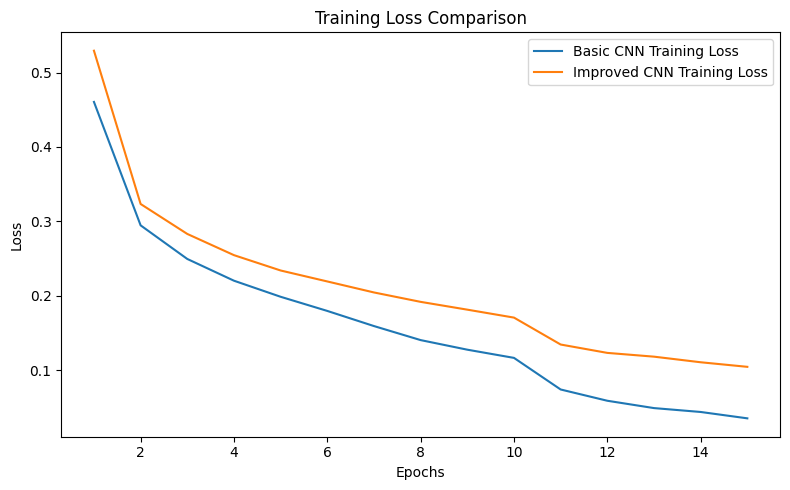

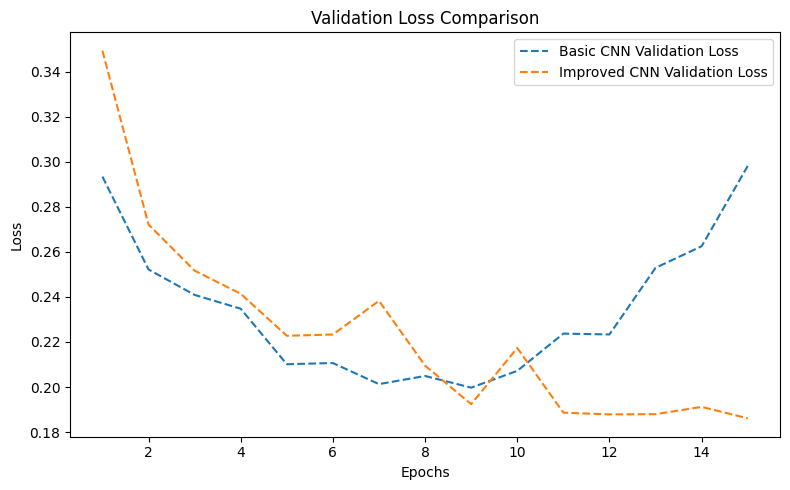

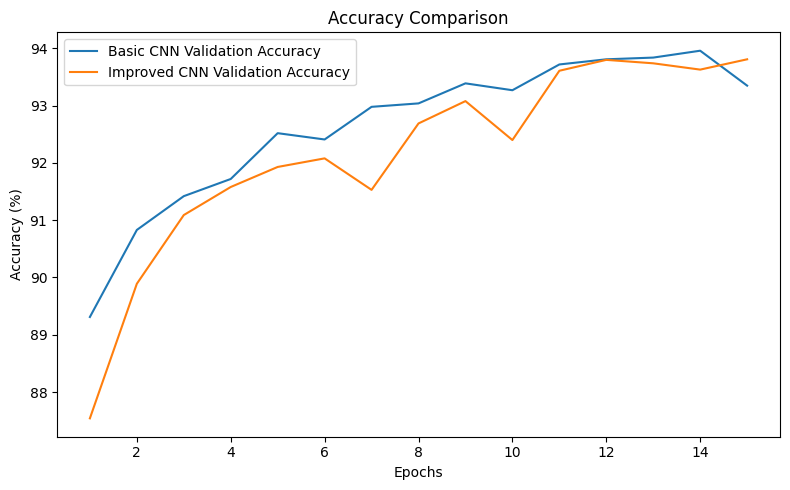

In [7]:
epochs = 15
print("\nTraining Basic CNN...")
basic_cnn = CNNModel().to(device)
basic_train_losses, basic_val_losses, basic_val_accs = train_and_validate(
    basic_cnn, train_loader_original, val_loader_cnn, epochs=epochs, model_name="BasicCNN"
)
print("\nTraining Improved CNN...")
improved_cnn = ImprovedCNN().to(device)
improved_train_losses, improved_val_losses, improved_val_accs = train_and_validate(
    improved_cnn, train_loader_original, val_loader_cnn, epochs=epochs, model_name="ImprovedCNN"
)
plot_grouped_results(
    [basic_train_losses, improved_train_losses],
    [basic_val_losses, improved_val_losses],
    [basic_val_accs, improved_val_accs],
    ["Basic CNN", "Improved CNN"]
)

### Conclusion for Section 3.1

- **Basic CNN**: Demonstrated reasonable performance for a simple architecture, achieving moderate accuracy on the validation set. However, it struggled with overfitting, as evidenced by the gap between training and validation accuracy. This limitation highlights the need for more sophisticated architectures to handle complex datasets like FashionMNIST.
- **ImprovedCNN**: Outperformed Basic CNN significantly in both training and validation accuracy. The deeper architecture, combined with advanced techniques such as LeakyReLU activation, Dropout regularization, and Global Average Pooling (GAP), contributed to better feature extraction and generalization. These enhancements reduced overfitting and improved the model's robustness.
- **Key Insight**: Structural improvements in CNNs, such as adding more layers and incorporating regularization techniques, are crucial for achieving better performance and generalization on image classification tasks.

## 3.2 Comparison of ImprovedCNN and Transfer Learning Models

Content of this section:
- **Transfer Learning Model Definitions**:
  - ResNet50: Loads ImageNet pre-trained weights, unfreezes all parameters, and the final fully connected layer outputs 10 classes.
  - MobileNetV2: Also loads pre-trained weights, classifier outputs 10 classes, lightweight structure.
- **Training and Validation**: Same process as ImprovedCNN, epoch=15, ensuring fair comparison.
- **Visualization**: Training/validation curves for all three models are compared to analyze the strengths and weaknesses of transfer learning models versus custom CNNs.

Transfer learning models can fully utilize features learned from large-scale datasets, making them suitable for small sample or new task scenarios. This section provides an intuitive analysis of the advantages and limitations of transfer learning.

In [8]:
from torchvision.models import ResNet50_Weights, MobileNet_V2_Weights

# Define ResNet50 transfer learning model
def get_resnet50():
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Unfreeze all parameters for training
    num_ftrs = model.fc.in_features  # Get the number of input features for the fully connected layer
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add Dropout layer to prevent overfitting
        nn.Linear(num_ftrs, 10)  # Modify the fully connected layer to output 10 classes
    )
    return model.to(device)

# Define MobileNetV2 transfer learning model
def get_mobilenetv2():
    model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True  # Unfreeze all parameters for training
    in_features = model.classifier[1].in_features  # Get the number of input features for the classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),  # Add Dropout layer to prevent overfitting
        nn.Linear(in_features, 10)
    )
    return model.to(device)

Train ImprovedCNN, ResNet50, and MobileNetV2, and visualize the training and validation performance of all three models.


Training Improved CNN...
ImprovedCNN Epoch: 1/15
Train Loss: 0.5251, Val Loss: 0.3686, Val Accuracy: 86.31%
ImprovedCNN Epoch: 2/15
Train Loss: 0.3211, Val Loss: 0.2870, Val Accuracy: 89.74%
ImprovedCNN Epoch: 3/15
Train Loss: 0.2790, Val Loss: 0.2828, Val Accuracy: 89.59%
ImprovedCNN Epoch: 4/15
Train Loss: 0.2525, Val Loss: 0.2370, Val Accuracy: 91.55%
ImprovedCNN Epoch: 5/15
Train Loss: 0.2304, Val Loss: 0.2387, Val Accuracy: 91.56%
ImprovedCNN Epoch: 6/15
Train Loss: 0.2171, Val Loss: 0.2252, Val Accuracy: 91.63%
ImprovedCNN Epoch: 7/15
Train Loss: 0.2032, Val Loss: 0.2297, Val Accuracy: 91.72%
ImprovedCNN Epoch: 8/15
Train Loss: 0.1917, Val Loss: 0.2058, Val Accuracy: 92.88%
ImprovedCNN Epoch: 9/15
Train Loss: 0.1793, Val Loss: 0.1963, Val Accuracy: 93.10%
ImprovedCNN Epoch: 10/15
Train Loss: 0.1687, Val Loss: 0.2159, Val Accuracy: 92.57%
ImprovedCNN Epoch: 11/15
Train Loss: 0.1324, Val Loss: 0.1805, Val Accuracy: 93.59%
ImprovedCNN Epoch: 12/15
Train Loss: 0.1226, Val Loss: 0.18

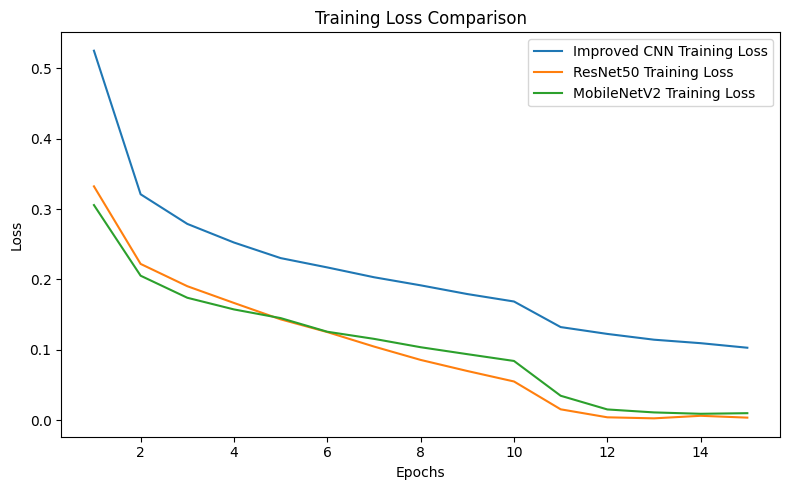

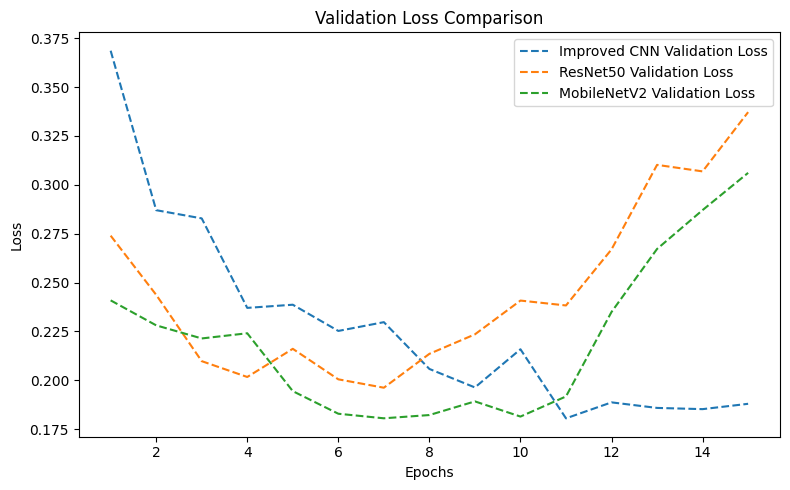

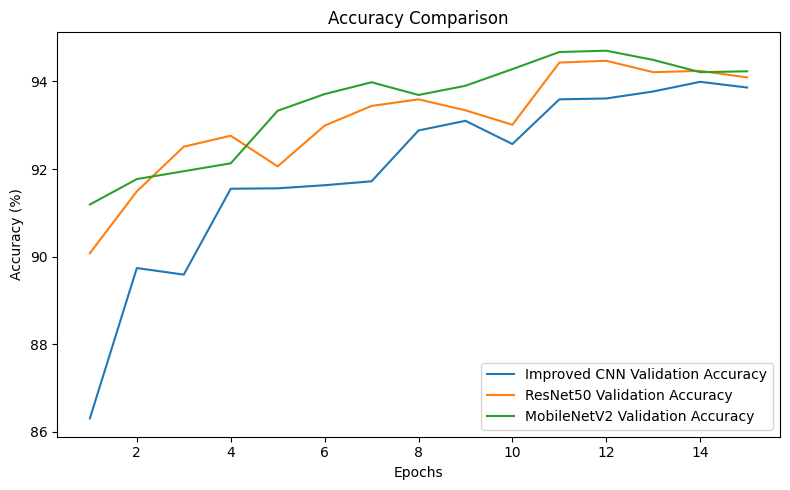

In [9]:
epochs = 15
print("\nTraining Improved CNN...")
improved_cnn = ImprovedCNN().to(device)
improved_train_losses, improved_val_losses, improved_val_accs = train_and_validate(
    improved_cnn, train_loader_original, val_loader_cnn, epochs=epochs, model_name="ImprovedCNN"
)
print("\nTraining ResNet50...")
resnet50 = get_resnet50()
resnet50_train_losses, resnet50_val_losses, resnet50_val_accs = train_and_validate(
    resnet50, train_loader_transfer, val_loader_transfer, epochs=epochs, model_name="ResNet50"
)
print("\nTraining MobileNetV2...")
mobilenetv2 = get_mobilenetv2()
mobilenetv2_train_losses, mobilenetv2_val_losses, mobilenetv2_val_accs = train_and_validate(
    mobilenetv2, train_loader_transfer, val_loader_transfer, epochs=epochs, model_name="MobileNetV2"
)


plot_grouped_results(
    [improved_train_losses, resnet50_train_losses, mobilenetv2_train_losses],
    [improved_val_losses, resnet50_val_losses, mobilenetv2_val_losses],
    [improved_val_accs, resnet50_val_accs, mobilenetv2_val_accs],
    ["Improved CNN", "ResNet50", "MobileNetV2"]
)

### Conclusion for Section 3.2

- **ImprovedCNN vs ResNet50**: ResNet50 achieved the highest accuracy among the models due to its pre-trained weights and deeper architecture. The ability to leverage features learned from large-scale datasets like ImageNet allowed ResNet50 to excel in extracting complex patterns, making it particularly effective for small datasets like FashionMNIST.
- **ImprovedCNN vs MobileNetV2**: MobileNetV2 provided competitive performance while being computationally efficient. Its lightweight design and depthwise separable convolutions enabled it to achieve high accuracy with lower resource requirements, making it suitable for deployment on devices with limited computational power.
- **Key Insight**: Transfer learning models, such as ResNet50 and MobileNetV2, demonstrate the power of pre-trained knowledge in achieving superior performance. While ResNet50 is ideal for scenarios requiring high accuracy, MobileNetV2 offers a balanced trade-off between performance and efficiency, making it a versatile choice for real-world applications.

## 3.3 Comparison of ImprovedCNN With and Without Data Augmentation

Content of this section:
- **Data Augmentation Parameters**:
  - Random horizontal flip (p=0.5)
  - Random crop (padding=2)
  - Random rotation (±10 degrees)
  - Brightness/contrast jitter (0.2)
  - Affine transformation (degrees=10, translation=0.05, scale=0.9~1.1)
  - Random erasing (p=0.2, area 0.02-0.05, ratio 0.5-2.0)
- **Training Comparison**: ImprovedCNN (without augmentation) vs ImprovedCNN (with augmentation), epoch=50, to analyze the improvement in generalization ability brought by data augmentation.

In [10]:
transform_cnn_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(28, padding=2),  # Reduce crop padding range
    transforms.RandomRotation(10),  # Reduce rotation angle to ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Reduce brightness and contrast jitter
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # Reduce translation and scaling range
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.05), ratio=(0.5, 2.0), value=0)  # Reduce random erasing area range
])
train_dataset_augmented = datasets.FashionMNIST(root='./data', train=True, transform=transform_cnn_train, download=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

Train ImprovedCNN with and without data augmentation, and compare their performance on the FashionMNIST dataset.


Training Improved CNN without Data Augmentation...
ImprovedCNN_NoAug Epoch: 1/50
Train Loss: 0.5200, Val Loss: 0.3258, Val Accuracy: 88.27%
ImprovedCNN_NoAug Epoch: 2/50
Train Loss: 0.3205, Val Loss: 0.2688, Val Accuracy: 90.36%
ImprovedCNN_NoAug Epoch: 3/50
Train Loss: 0.2746, Val Loss: 0.2533, Val Accuracy: 90.57%
ImprovedCNN_NoAug Epoch: 4/50
Train Loss: 0.2504, Val Loss: 0.2214, Val Accuracy: 91.84%
ImprovedCNN_NoAug Epoch: 5/50
Train Loss: 0.2282, Val Loss: 0.2733, Val Accuracy: 90.27%
ImprovedCNN_NoAug Epoch: 6/50
Train Loss: 0.2128, Val Loss: 0.2364, Val Accuracy: 91.54%
ImprovedCNN_NoAug Epoch: 7/50
Train Loss: 0.2031, Val Loss: 0.2038, Val Accuracy: 92.62%
ImprovedCNN_NoAug Epoch: 8/50
Train Loss: 0.1889, Val Loss: 0.2000, Val Accuracy: 92.69%
ImprovedCNN_NoAug Epoch: 9/50
Train Loss: 0.1789, Val Loss: 0.1990, Val Accuracy: 92.89%
ImprovedCNN_NoAug Epoch: 10/50
Train Loss: 0.1683, Val Loss: 0.1967, Val Accuracy: 93.20%
ImprovedCNN_NoAug Epoch: 11/50
Train Loss: 0.1307, Val Lo

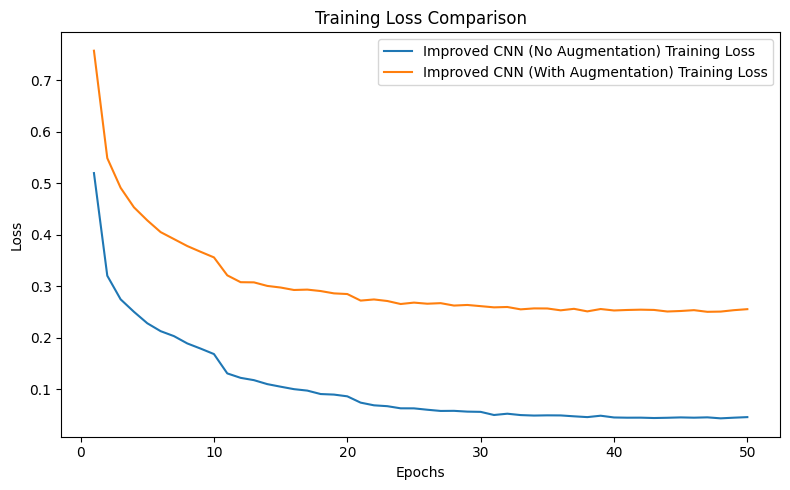

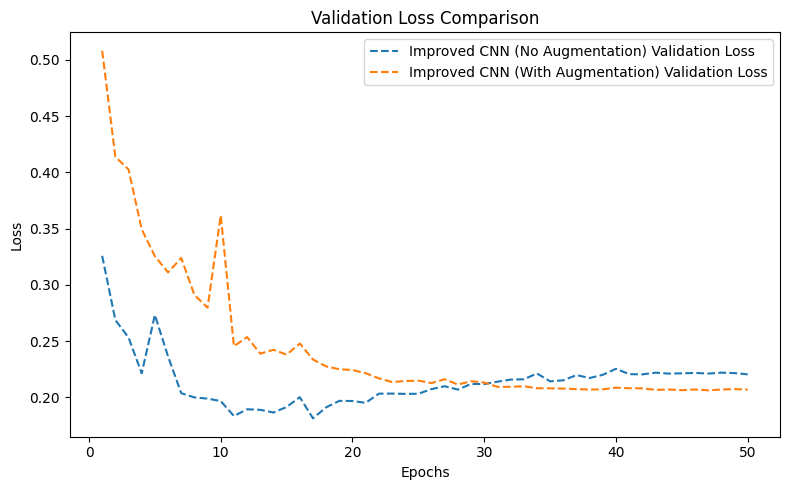

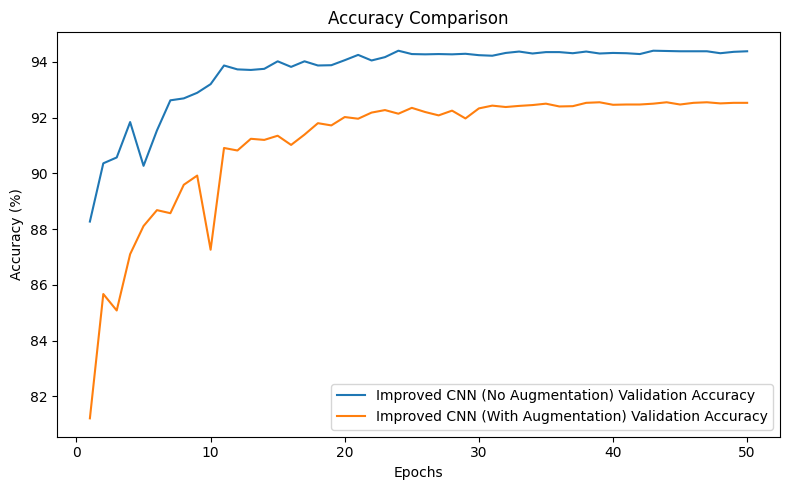

In [11]:
epochs = 50
print("\nTraining Improved CNN without Data Augmentation...")
improved_cnn_no_aug = ImprovedCNN().to(device)
improved_no_aug_train_losses, improved_no_aug_val_losses, improved_no_aug_val_accs = train_and_validate(
    improved_cnn_no_aug, train_loader_original, val_loader_cnn, epochs=epochs, model_name="ImprovedCNN_NoAug"
    )
print("\nTraining Improved CNN with Data Augmentation...")
improved_cnn_aug = ImprovedCNN().to(device)
improved_aug_train_losses, improved_aug_val_losses, improved_aug_val_accs = train_and_validate(
    improved_cnn_aug, train_loader_augmented, val_loader_cnn, epochs=epochs, model_name="ImprovedCNN_Aug"
    )
plot_grouped_results(
    [improved_no_aug_train_losses, improved_aug_train_losses],
    [improved_no_aug_val_losses, improved_aug_val_losses],
    [improved_no_aug_val_accs, improved_aug_val_accs],
    ["Improved CNN (No Augmentation)", "Improved CNN (With Augmentation)"]
)

### Conclusion for Section 3.3

- **Effect of Data Augmentation**: Contrary to expectations, the ImprovedCNN model trained with data augmentation did not achieve higher accuracy than the model trained without augmentation. While augmentation is generally intended to improve generalization, in this experiment, the validation accuracy was slightly lower or similar compared to the non-augmented model.
- **Overfitting Prevention**: Despite the lack of accuracy improvement, data augmentation still played a valuable role in reducing overfitting. The training and validation curves indicate that the model with augmentation had a smaller gap between training and validation accuracy, suggesting better generalization and less memorization of the training data. This means the model is less likely to fit noise or specific patterns in the training set, which is especially important for small or simple datasets.
- **Possible Reasons**: This outcome may be due to several factors, such as the choice or intensity of augmentation techniques, the relatively simple nature of the FashionMNIST dataset, or the model's capacity being sufficient to generalize well without augmentation. Over-augmentation or inappropriate augmentation parameters can sometimes make the learning task harder, especially for simpler datasets.
- **Key Insight**: Data augmentation does not always guarantee improved performance in terms of accuracy, but it is an effective strategy for preventing overfitting and improving model robustness. It is important to carefully select and tune augmentation strategies based on the dataset and model. For FashionMNIST, moderate or minimal augmentation may be more effective, and further experimentation with different augmentation settings could help identify the optimal approach.